# Variational Autoencoders (VAE) using SELFIES, implementation on nanoHUB

<i>Juan Carlos Verduzco</i> and <i>Alejandro Strachan</i>, Materials Engineering, Purdue University <br>

### References

<b> Based on work published on: </b> [Krenn et al.](https://iopscience.iop.org/article/10.1088/2632-2153/aba947/meta) <br> 


<b> Original notebooks: </b> <br>
<b> Self-Referencing Embedded Strings (SELFIES): A 100% robust molecular string representation</b>  <br>
<i> Mario Krenn, Florian Haese, AkshatKumar Nigam, Pascal Friederich, Alan Aspuru-Guzik </i> <br>

Their Github implementation can be found [here](https://github.com/aspuru-guzik-group/selfies).
<br>

## Overview

The following notebook implements methods developed by <b>Krenn et al. </b> to introduce and test the SELFIES robust molecular representation.
This notebook aims to keep a snapshot of the repository code with a set environment for future reproduciblity tests. Moreover, users can modify the code
to explore different models, try new ideas and adapt them for their own problems.

**Outline:**

1. SMILES and SELFIES Representations <br>
2. Generative Models: Variational Autoencoders <br>
    2.1 Setting up Inputs <br>
    2.2 Visualizing Data <br>
    2.3 Defining the VAE architecture <br>
3. Training <br>
 
## Getting started and hints

 * Click on the links below to access each notebook.
 * Remember to click "Shift+Return" or click "Run" from the top bar to run each cell
 * "Terminate Session" (top right) will kill your entire Jupyter session.
 * The notebooks are read only, you can make your own copy by downloading the notebook file (Menu File -> Download as... > Notebook (.ipynb)). You can upload this notebook to your main Jupyter directory within nanoHUB to run it again.

### Libraries

In [1]:
# General Use

import os
import sys
import time
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
import seaborn as sns


# Chemistry 
from rdkit import rdBase
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
from rdkit.Chem import PandasTools
rdBase.DisableLog('rdApp.error')

# Selfies Library 
import selfies as sf
from data_loader import multiple_selfies_to_hot, multiple_smile_to_hot, selfies_to_hot
from selfies_functions import _make_dir, save_models, is_correct_smiles, get_selfie_and_smiles_encodings_for_dataset, \
                            sample_latent_space, latent_space_quality, quality_in_valid_set, compute_elbo, compute_recon_quality

# Neural Network Packages
import torch
from torch import nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\prate\anaconda3\envs\chemprop\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---
## 1. SMILES AND SELFIES Representations

The Simplified Molecular Input Line System (SMILES) chemical notation language was introduced in the following [paper](https://pubs.acs.org/doi/pdf/10.1021/ci00057a005) by David Weininger in 1988. It was created as a standardized representation of molecular chemical structures for use in computational programs. 

The rules followed by SMILES are simple and user-friendly. You can find all the detailed descriptions in the paper, and a very descriptive explanation [here](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system). In short,

* Atoms are represented by their atomic symbols (excluding H, which is not represented).
    * Atoms not in the organic subset and formal charges need to be included in brackets \[ \].
* Common bonds are shown as symbols - (single bond), = (double bond), and # (triple bond)
    * Single bonds are usually not written as they are implied by adjacency
* Branches are represented by enclosed parenthesis.
* Aromatic Rings are written in lowercase letters

In the non-canonical SMILES notation, there could be more than one valid description of the same structure. In a subsequent paper, [Weininger et al.](https://pubs.acs.org/doi/pdf/10.1021/ci00062a008) described a method to have unique canonical SMILES.

Benzene SMILES: C1=CC=CC=C1 



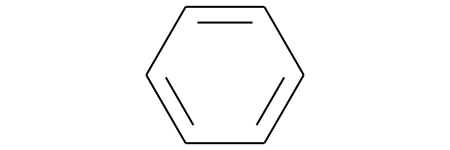

TNT (2,4,6-Trinitrotoluene) SMILES: CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-] 



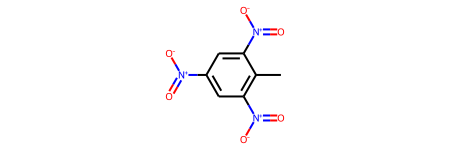

In [2]:
# Some examples of SMILES representations

benzene_smiles = "C1=CC=CC=C1"
benzene_image = Chem.MolFromSmiles(benzene_smiles)
print(f"Benzene SMILES: {benzene_smiles} \n")
display(benzene_image)


tnt_smiles = "CC1=C(C=C(C=C1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[O-]"
tnt_image = Chem.MolFromSmiles(tnt_smiles)
print(f"TNT (2,4,6-Trinitrotoluene) SMILES: {tnt_smiles} \n")
display(tnt_image)

***
From their introduction, SMILES strings have become a standard tool for representation of molecules in computational chemistry. Several models have made use of them to predict properties with remarkable accuracies. More recently, advances in computational methods and algorithms using machine learning, in particular **generative models** like Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs), have opened the possibility of efficiently designing novel molecules with superior properties.

However, implementation of these generative models when using SMILES representation inputs usually result in strings that do not represent valid molecules due to syntax errors or chemistry valence rules. On 2020, [Krenn et al.](https://iopscience.iop.org/article/10.1088/2632-2153/aba947/meta) introduced the SELF-referencing Embedded Strings (SELFIES), a more robust representation in which each string corresponds to a valid molecule. Details on their derivation can be found in the paper itself, Figure 2.

Some of the key aspects that differentiate SELFIES from SMILES are:
* Identifiers for \[Ring\] and \[Branch\]
* A new derivation table that takes care of syntactical and chemical constraints.

Original SMILES: CC(=O)OC1=CC=CC=C1C(=O)O 



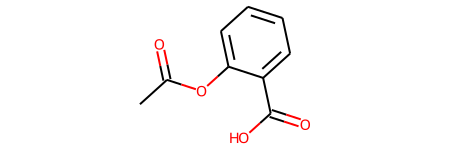

Translated SELFIES: [C][C][=Branch1][C][=O][O][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=Branch1][C][=O][O] 

Translated SMILES: CC(=O)OC1=CC=CC=C1C(=O)O 



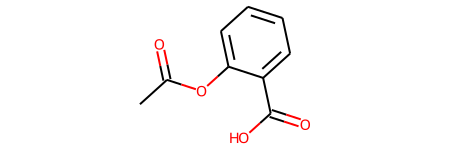

RDKit Equals: True


In [3]:
# Now, a brief demonstration of the representations with SELFIES


# We start with a known SMILES string, in our example this is the representation for Aspirin 
smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"

# From the examples in the documentation, here's also a non-fullerene acceptor for organic solar cells
#smiles = "CN1C(=O)C2=C(c3cc4c(s3)-c3sc(-c5ncc(C#N)s5)cc3C43OCCO3)N(C)C(=O)C2=C1c1cc2c(s1)-c1sc(-c3ncc(C#N)s3)cc1C21OCCO1"

print(f"Original SMILES: {smiles} \n")

# We can also visualize the molecule itself from the SMILES string
can_image = Chem.MolFromSmiles(smiles)
display(can_image)

# We can then transform this SMILES string into the new SELFIES string representation
encoded_selfies = sf.encoder(smiles)  # SMILES --> SEFLIES
print(f"Translated SELFIES: {encoded_selfies} \n")

# Conversely, we can transform the SELFIES string back into the SMILES representation
decoded_smiles = sf.decoder(encoded_selfies)  # SELFIES --> SMILES
print(f"Translated SMILES: {decoded_smiles} \n")


# We can visualize the molecule now after the two transformations
can_decoded_image = Chem.MolFromSmiles(decoded_smiles)
display(can_decoded_image)



# Following the original code of the repository,
# we can analyze if the ORIGINAL molecule representation is the same as the one that was transformed and transformed back. 
can_smiles = Chem.CanonSmiles(smiles)
can_decoded_smiles = Chem.CanonSmiles(decoded_smiles)
print(f"RDKit Equals: {can_smiles == can_decoded_smiles}")

---
## 2. Generative Models: Variational Autoencoders

###    2.1 Setting up Inputs

Following the repository provided by the original authors, all inputs that can be modified by the user are compiled in a single YAML readable file.

You can create this file in the cell below by modifying the descriptive tags. In this file, we provide:

* Aspects of the processing of the data / dataset
* Characteristics of the architecture network (encoder and decoder)
* Hyperparameters for the training stage

In [4]:
settings_string ='''data:
  batch_size: 100
  smiles_file: 0SelectedSMILES_QM9.txt
  type_of_encoding: 1

decoder:
  latent_dimension: 50
  gru_neurons_num: 100
  gru_stack_size: 1

encoder:
  layer_1d: 100
  layer_2d: 100
  layer_3d: 100
  latent_dimension: 50

training:
  KLD_alpha: 1.0e-05
  lr_enc: 0.0001
  lr_dec: 0.0001
  num_epochs: 200
  sample_num: 1000

'''

settings_file = open('settings.yml', 'w')
settings_file.write(settings_string)
settings_file.close()

*** 
###    2.2 Getting and Visualizing Data

Data provided from the paper comes from the [QM9 Dataset](http://quantum-machine.org/datasets/), in which 134,000 stable small organic molecules made up of CHONF were collected with the aim of helping computational design of new materials via exploration of the high-dimensional chemical space. 

Code in the following cell will query the dataset and import the selected representation (SMILES or SELFIES) to the notebook. As with most machine learning models that make use of non-numeric categorial inputs, these representations need to pass a secondary transformation as [one-hot encodings](https://en.wikipedia.org/wiki/One-hot). This encoding effectively transforms the inputs into a matrix of zeros and ones that represents each entry.  

In [5]:
# Creation of files to store results

content = open('logfile.dat', 'w')
content.close()
content = open('results.dat', 'w')
content.close()


# This snippet of code checks for the creation of the "settings.yml" file we created a few cells before this one. Make sure to run that cell before this one. 

if os.path.exists("settings.yml"):
    settings = yaml.safe_load(open("settings.yml", "r"))
else:
    print("Expected a file settings.yml but didn't find it.")

    
# Importing Data 

print('--> Acquiring data...')
type_of_encoding = settings['data']['type_of_encoding'] # Type of Encoding specifies whether to train with SMILES (Encoding = 0) or SELFIES (Encoding = 1)
file_name_smiles = settings['data']['smiles_file'] # This variable specifies the location of the dataset file 
print('Finished acquiring data.')


# Encoding the data as SMILES (This is not related to the VAE encoder, this is just how the data is represented)

if type_of_encoding == 0:
    print('Representation: SMILES')
    _, _, _, encoding_list, encoding_alphabet, largest_molecule_len = \
        get_selfie_and_smiles_encodings_for_dataset(file_name_smiles)
    
    # Variable {encoding_list} is a list of all the molecules in the respective representation (SMILES or SELFIES)
    # Variable {encoding_alphabet} is a list of the tags used by the representation (All the symbols)
    # Variable {largest_molecule_len} stores the length of the largest string representation of a molecule in the dataset
    
    
    # After getting these variables, machine learning models usually make use of one-hot encodings.
    
    print('--> Creating one-hot encoding...')
    data = multiple_smile_to_hot(encoding_list, largest_molecule_len,
                                 encoding_alphabet)
    print('Finished creating one-hot encoding.')
    
# Encoding the data as SELFIES (This is not related to the VAE encoder, this is just how the data is represented)

elif type_of_encoding == 1:
    print('Representation: SELFIES')
    encoding_list, encoding_alphabet, largest_molecule_len, _, _, _ = \
        get_selfie_and_smiles_encodings_for_dataset(file_name_smiles)

    print('--> Creating one-hot encoding...')
    data = multiple_selfies_to_hot(encoding_list, largest_molecule_len,
                                   encoding_alphabet)
    print('Finished creating one-hot encoding.')

else:
    print("type_of_encoding not in {0, 1}.")

    
# Variable {data} is an array of all the one-hot representations
   
len_max_molec = data.shape[1]
len_alphabet = data.shape[2]
len_max_mol_one_hot = len_max_molec * len_alphabet

print(' ')
print(f"Alphabet has {len_alphabet} letters, "
      f"largest molecule is {len_max_molec} letters.")

print(f"Dataset contains {len(encoding_list)} molecules")

--> Acquiring data...
Finished acquiring data.
Representation: SELFIES
--> Translating SMILES to SELFIES...
Finished translating SMILES to SELFIES.
--> Creating one-hot encoding...
Finished creating one-hot encoding.
 
Alphabet has 18 letters, largest molecule is 21 letters.
Dataset contains 132040 molecules


We can visualize each of this one-hot encoded representations as a matrix.

For the code, the columns are the tags used by the SMILES / SELFIES strings and the rows is the position in the molecule representation.
To make a more intuitive visualization, we are plotting the **transposed version of the matrix**.

In [ ]:
# Here we select a random molecule
index = 10
print(f"Representation of molecule {index}: {encoding_list[index]}")

# As we did before, we can get a rendering of the molecule
decoded_smiles_index = sf.decoder(encoding_list[index])  # SELFIES --> SMILES
can_decoded_image_index = Chem.MolFromSmiles(decoded_smiles_index)
display(can_decoded_image_index)


# And here we create a plot showing the matrix

transposed = data[index].T

map_colors = pltcolors.ListedColormap(["lightgray", "gold"])
fig, (ax1) = plt.subplots(1,1, figsize=(14,8))
sns.heatmap(transposed, ax=ax1, cbar=False, cmap=map_colors, linewidth=1)
ax1.set_yticklabels(encoding_alphabet, fontsize=20, rotation=360)

plt.ylabel('Character', fontsize=28)
ax1.set_xlabel('Position in SMILES/SELFIES string', fontsize=28)
plt.tight_layout()
plt.show()

###    2.3 Defining the VAE architecture

Taking the characteristics of the architecture network, the following cells create classes for the VAE-Encoder and VAE-Decoder. The architecture represented here follows the repository of the original paper. 

In [6]:
'''
Note how the parameters from the settings.yml file we created at the beginning are referenced here too.

encoder:
  layer_1d: XXX
  layer_2d: XXX
  layer_3d: XXX
  latent_dimension: XXX
'''

class VAEEncoder(nn.Module):

    def __init__(self, in_dimension, layer_1d, layer_2d, layer_3d,
                 latent_dimension):
        """
        Fully Connected layers to encode molecule to latent space
        """
        super(VAEEncoder, self).__init__()
        self.latent_dimension = latent_dimension

        # Reduce dimension up to second last layer of Encoder
        self.encode_nn = nn.Sequential(
            nn.Linear(in_dimension, layer_1d),
            nn.ReLU(),
            nn.Linear(layer_1d, layer_2d),
            nn.ReLU(),
            nn.Linear(layer_2d, layer_3d),
            nn.ReLU()
        )

        # Latent space mean
        self.encode_mu = nn.Linear(layer_3d, latent_dimension)

        # Latent space variance
        self.encode_log_var = nn.Linear(layer_3d, latent_dimension)

    @staticmethod
    def reparameterize(mu, log_var):
        """
        This trick is explained well here:
            https://stats.stackexchange.com/a/16338
        """
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        """
        Pass throught the Encoder
        """
        # Get results of encoder network
        h1 = self.encode_nn(x)

        # latent space
        mu = self.encode_mu(h1)
        log_var = self.encode_log_var(h1)

        # Reparameterize
        z = self.reparameterize(mu, log_var)
        return z, mu, log_var

In [7]:
'''
Note how the parameters from the settings.yml file we created at the beginning are referenced here too.

decoder:
  latent_dimension: 50
  gru_neurons_num: 100
  gru_stack_size: 1
'''

class VAEDecoder(nn.Module):

    def __init__(self, latent_dimension, gru_stack_size, gru_neurons_num,
                 out_dimension):
        """
        Through Decoder
        """
        super(VAEDecoder, self).__init__()
        self.latent_dimension = latent_dimension
        self.gru_stack_size = gru_stack_size
        self.gru_neurons_num = gru_neurons_num

        # Simple Decoder
        self.decode_RNN = nn.GRU(
            input_size=latent_dimension,
            hidden_size=gru_neurons_num,
            num_layers=gru_stack_size,
            batch_first=False)

        self.decode_FC = nn.Sequential(
            nn.Linear(gru_neurons_num, out_dimension),
        )

    def init_hidden(self, batch_size=1):
        weight = next(self.parameters())
        return weight.new_zeros(self.gru_stack_size, batch_size,
                                self.gru_neurons_num)

    def forward(self, z, hidden):
        """
        A forward pass throught the entire model.
        """

        # Decode
        l1, hidden = self.decode_RNN(z, hidden)
        decoded = self.decode_FC(l1)  # fully connected layer

        return decoded, hidden

## 3. Training

After the data has been queried and processed, and the architecture of the network created, we can start thinking about training it. In the following cell, authors created a training function that takes the objects we created for the VAE-Encoder and VAE-Decoder and the hyperparameters from the **"settings.yml"** file we created. 

In [8]:
def train_model(vae_encoder, vae_decoder,
                data_train, data_valid, num_epochs, batch_size,
                lr_enc, lr_dec, KLD_alpha,
                sample_num, sample_len, alphabet, type_of_encoding):
    """
    Train the Variational Auto-Encoder
    """

    print('num_epochs: ', num_epochs)

    # initialize an instance of the model
    optimizer_encoder = torch.optim.Adam(vae_encoder.parameters(), lr=lr_enc) # Here the method .parameters() returns the trainable parameters of the network (weights/biases)
    optimizer_decoder = torch.optim.Adam(vae_decoder.parameters(), lr=lr_dec) # The argument "lr" indicates the learning rate for the optimizer

    data_train = data_train.clone().detach().to(device)          # Sending the training data to the GPU
    num_batches_train = int(len(data_train) / batch_size)        # Calculating the number of batches to processes 

    quality_valid_list = [0, 0, 0, 0]
        
    for epoch in range(num_epochs):

        data_train = data_train[torch.randperm(data_train.size()[0])] # Data shuffling

        start = time.time()
        for batch_iteration in range(num_batches_train):  # batch iterator

            # manual batch iterations
            start_idx = batch_iteration * batch_size
            stop_idx = (batch_iteration + 1) * batch_size
            batch = data_train[start_idx: stop_idx]

            # reshaping for efficient parallelization
            inp_flat_one_hot = batch.flatten(start_dim=1)
            

            
            latent_points, mus, log_vars = vae_encoder(inp_flat_one_hot)
            
            # initialization hidden internal state of RNN (RNN has two inputs
            # and two outputs:)
            #    input: latent space & hidden state
            #    output: one-hot encoding of one character of molecule & hidden
            #    state the hidden state acts as the internal memory
            latent_points = latent_points.unsqueeze(0)
            hidden = vae_decoder.init_hidden(batch_size=batch_size)

            
                    
            # decoding from RNN N times, where N is the length of the largest
            # molecule (all molecules are padded)
            out_one_hot = torch.zeros_like(batch, device=device)
            for seq_index in range(batch.shape[1]):
                out_one_hot_line, hidden = vae_decoder(latent_points, hidden)
                out_one_hot[:, seq_index, :] = out_one_hot_line[0]

            # compute ELBO
            loss = compute_elbo(batch, out_one_hot, mus, log_vars, KLD_alpha)

            # perform back propogation
            optimizer_encoder.zero_grad()
            optimizer_decoder.zero_grad()
            loss.backward(retain_graph=True)
            nn.utils.clip_grad_norm_(vae_decoder.parameters(), 0.5)
            optimizer_encoder.step()
            optimizer_decoder.step()

            if batch_iteration % 30 == 0:
                end = time.time()

                # assess reconstruction quality
                quality_train = compute_recon_quality(batch, out_one_hot)
                
                
                
                
                quality_valid = quality_in_valid_set(vae_encoder, vae_decoder,
                                                     data_valid, batch_size)

                report = 'Epoch: %d,  Batch: %d / %d,\t(loss: %.4f\t| ' \
                         'quality: %.4f | quality_valid: %.4f)\t' \
                         'ELAPSED TIME: %.5f' \
                         % (epoch, batch_iteration, num_batches_train,
                            loss.item(), quality_train, quality_valid,
                            end - start)
                #print(report)
                start = time.time()

        quality_valid = quality_in_valid_set(vae_encoder, vae_decoder,
                                             data_valid, batch_size)
        quality_valid_list.append(quality_valid)

        # only measure validity of reconstruction improved
        quality_increase = len(quality_valid_list) \
                           - np.argmax(quality_valid_list)
        if quality_increase == 1 and quality_valid_list[-1] > 50.:
            corr, unique = latent_space_quality(vae_encoder, vae_decoder,
                                                type_of_encoding, alphabet,
                                                sample_num, sample_len)
        else:
            corr, unique = -1., -1.

        report = 'Validity: %.5f %% | Diversity: %.5f %% | ' \
                 'Reconstruction: %.5f %%' \
                 % (corr * 100. / sample_num, unique * 100. / sample_num,
                    quality_valid)
        print(report)

        with open('results.dat', 'a') as content:
            content.write(report + '\n')

        if quality_valid_list[-1] < 70. and epoch > 200:
            break

        if quality_increase > 20:
            print('Early stopping criteria')
            break


    save_models(vae_encoder, vae_decoder, epoch)
    return epoch

Finally, we can put it all together by calling all the functions we created in the previous cells.

In [9]:
# Querying parameters from "settings.yml"

data_parameters = settings['data']
batch_size = data_parameters['batch_size']

encoder_parameter = settings['encoder']
decoder_parameter = settings['decoder']
training_parameters = settings['training']

# Creating instances of the classes for the encoder / decoder 
# The ** operator unpacks all the arguments stored in that variable from the YAML file
# The ".to(device)" method sends the model objects to the GPU

vae_encoder = VAEEncoder(in_dimension=len_max_mol_one_hot,
                         **encoder_parameter).to(device)

vae_decoder = VAEDecoder(**decoder_parameter,
                         out_dimension=len(encoding_alphabet)).to(device)


print('*' * 15, ': -->', device) # This print indicates if you are running on a CPU ('cpu') or in a GPU ('cuda')

data = torch.tensor(data, dtype=torch.float).to(device) # Converting the array {data} to a Pytorch Tensor and sending it to a GPU


# Datasets for training/validation/testing

train_valid_test_size = [0.5, 0.5, 0.0] # Training / Validation / Testing Split
data = data[torch.randperm(data.size()[0])] # Shuffling

idx_train_val = int(len(data) * train_valid_test_size[0])
idx_val_test = idx_train_val + int(len(data) * train_valid_test_size[1])

data_train = data[0:idx_train_val]
data_valid = data[idx_train_val:idx_val_test]


#Training 

print("start training")
epoch = train_model(**training_parameters,
            vae_encoder=vae_encoder,
            vae_decoder=vae_decoder,
            batch_size=batch_size,
            data_train=data_train,
            data_valid=data_valid,
            alphabet=encoding_alphabet,
            type_of_encoding=type_of_encoding,
            sample_len=len_max_molec)

with open('COMPLETED', 'w') as content:
    content.write('exit code: 0')

*************** : --> cuda
start training
num_epochs:  200
latent_space_quality: Take 1000 samples from the latent space
Validity: 71.60000 % | Diversity: 12.00000 % | Reconstruction: 65.63238 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 72.80000 % | Diversity: 13.00000 % | Reconstruction: 65.83238 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 73.00000 % | Diversity: 14.00000 % | Reconstruction: 65.88762 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 65.55810 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 65.88571 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 73.80000 % | Diversity: 17.20000 % | Reconstruction: 66.26286 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 66.24190 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 75.00000 % | Diversity: 18.30000 % | Reconstruction: 66.91429 %
latent_space_quality: Take 1000 samples

latent_space_quality: Take 1000 samples from the latent space
Validity: 84.70000 % | Diversity: 29.10000 % | Reconstruction: 82.47619 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 82.31429 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 82.10000 % | Diversity: 28.20000 % | Reconstruction: 83.08190 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 82.38476 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 82.54476 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 82.79429 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 82.80381 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 85.70000 % | Diversity: 29.00000 % | Reconstruction: 83.55429 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 82.00000 % | Diversity: 27.00000 % | Reconstruction: 83.57905 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 83.08762 %
Validity: -0

latent_space_quality: Take 1000 samples from the latent space
Validity: 82.80000 % | Diversity: 36.10000 % | Reconstruction: 91.85524 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 91.59238 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 83.10000 % | Diversity: 33.70000 % | Reconstruction: 91.91238 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 84.40000 % | Diversity: 35.30000 % | Reconstruction: 92.00190 %
Validity: -0.10000 % | Diversity: -0.10000 % | Reconstruction: 91.96952 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 85.80000 % | Diversity: 37.30000 % | Reconstruction: 92.08381 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 82.60000 % | Diversity: 34.20000 % | Reconstruction: 92.31238 %
latent_space_quality: Take 1000 samples from the latent space
Validity: 85.20000 % | Diversity: 36.10000 % | Reconstruction: 92.31810 %
latent_space_quality: Take 1000 samp

In [10]:
vae_encoder = torch.load('./saved_models/{}/E'.format(199)) #
vae_encoder.eval()

VAEEncoder(
  (encode_nn): Sequential(
    (0): Linear(in_features=378, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
  )
  (encode_mu): Linear(in_features=100, out_features=50, bias=True)
  (encode_log_var): Linear(in_features=100, out_features=50, bias=True)
)

In [11]:
vae_decoder = torch.load('./saved_models/{}/D'.format(199))
vae_decoder.eval()

VAEDecoder(
  (decode_RNN): GRU(50, 100)
  (decode_FC): Sequential(
    (0): Linear(in_features=100, out_features=18, bias=True)
  )
)

Original SMILES: CC(=O)OC1=CC=CC=C1C(=O)O 



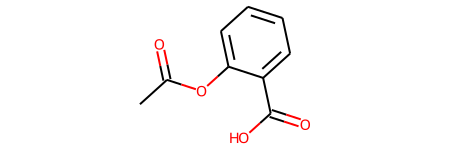

Translated SELFIES: [C][C][=Branch1][C][=O][O][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=Branch1][C][=O][O] 

tensor([ 2,  2,  6,  2, 17,  2,  2,  5,  2, 16,  2,  5, 16,  2, 17,  2,  2, 13,
        13, 13, 13], device='cuda:0')
tensor([1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0.,
        0., 1., 1.], device='cuda:0', dtype=torch.float64)
57.14285714285714
[C][C][=Branch1][C][=N][C][C][=C][C][Branch1][C][=C][Branch1][C][=N][C][C][nop][nop][nop][nop]
CC(=N)CC=CC(C)(N)CC


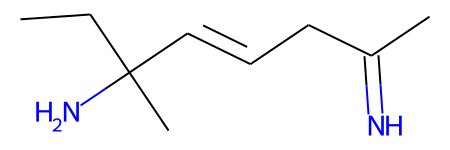

In [20]:
# RANDOM TENSOR
fancy_latent_point = torch.randn(1, 1, vae_encoder.latent_dimension,
                                 device=device)




# FROM EXAMPLE TENSOR (FOR RECONSTRUCTION TESTING)

# We start with a known SMILES string, in our example this is the representation for an organic molecule

# QM9
#smiles = "CCCCC"
# smiles = "CC#CC(=O)C(C)CO"
smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
#Donor
# smiles = "CC(SC1=C2C3=CC=C(CC(CC)CCCC)S3)=CC1=C(C4=CC=C(CC(CC)CCCC)S4)C5=C2C=C(C6=CC7=C(C(SC(C)=C8)=C8C(N7CC(CCCCCCCC)CCCCCCCCCC)=O)S6)S5"
# smiles = "CC1=CC(CCCCCC)=C(C)S1"
#Acceptor
# smiles = "CCCCCC(N(C(C1=CC=C2C(C=CC34)=C5C4C(C(N(C6=CC=C(C7(CCCCC7)C8=CC=C(N(C9=O)C(C%10=CC=C%11C%12=C(C%13=CC=C(C%14=C%13C%11=CC=C%15%14)C(N(C%15=O)C(CCCCC)CCCCC)=O)C=CC9C%10%12)=O)C=C8)C=C6)C3=O)=O)=CC=C5C%16=CC=C%17C1=C2%16)=O)C%17=O)CCCCC"
# smiles = "O=C(N1CCCCCC)C2=CC(C3=C4C5=C(C6=C3)C(C7=C58)=C(C=C6)C=CC7=CC=C8C=C4)=CC=C2C1=O"
# smiles = "COC1=CC(C2C3C=CC(OC)=C2)=C(/C3=C4C(C=C(C=CC=C5)C5=C6)=C6C7=C/4C=C8C(C=CC=C8)=C7)C=C1"
# smiles = "O=C(C(C=CC=C1)=C1C/2=C(C#N)/C#N)C2=C/C3=CC(SC4=C5C(C6=CC=C(CCC)C=C6)(C7=CC=C(CCC)C=C7)C8=C4SC9=C8C(CCCCCCCCCCCC)=C%10SC%11=C(C%10=C9CCCCCCCCCCCC)C(C%12=CC=C(CCC)C=C%12)(C%13=CC=C(CCC)C=C%13)C%14=C%11SC%15=C%14SC(/C=C%16C(C(C=CC=C%17)=C%17C\%16=C(C#N)\C#N)=O)=C%15)=C5S3"
print(f"Original SMILES: {smiles} \n")

# We can also visualize the molecule itself from the SMILES string
can_image = Chem.MolFromSmiles(smiles)
display(can_image)

# We can then transform this SMILES string into the new SELFIES string representation
encoded_selfies = sf.encoder(smiles)  # SMILES --> SEFLIES
print(f"Translated SELFIES: {encoded_selfies} \n")


example = multiple_selfies_to_hot([encoded_selfies], largest_molecule_len, encoding_alphabet)
example = torch.tensor(example, dtype=torch.float).to(device)


out_one_hot = torch.zeros_like(example, device=device)
one_hot_flat_example = example.flatten(start_dim=1)


example_latent_point, example_mu, example_log_var = vae_encoder(one_hot_flat_example)
example_latent_point = example_latent_point.unsqueeze(0)

# print(example_latent_point)
# print(type(example_latent_point))
# print(example_latent_point.shape)

hidden = vae_decoder.init_hidden(batch_size=1)

# runs over letters from molecules (len=size of largest molecule)

for seq_index in range(21):
    out_one_hot_line, hidden = vae_decoder(example_latent_point, hidden)
    out_one_hot[:,seq_index] = out_one_hot_line[0]
    
    
example_indices = example.reshape(-1, example.shape[2]).argmax(1)
out_one_hot_indices = out_one_hot.reshape(-1, out_one_hot.shape[2]).argmax(1)

differences = 1. - torch.abs(out_one_hot_indices - example_indices)
differences = torch.clamp(differences, min=0., max=1.).double()

quality = 100. * torch.mean(differences)
quality = quality.detach().cpu().numpy()

print(out_one_hot_indices)
print(differences)
print(quality)


sampled_selfies = ''.join([encoding_alphabet[tag] for tag in out_one_hot_indices])
print(sampled_selfies)

sampled_selfies_index = sf.decoder(sampled_selfies)  # SELFIES --> SMILES
print(sampled_selfies_index)
sampled_selfies_image = Chem.MolFromSmiles(sampled_selfies_index)
display(sampled_selfies_image)

CC#CC(=O)C(C)CO


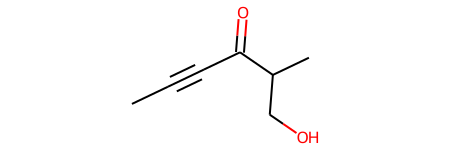

CC#CC(=O)C(C)CO


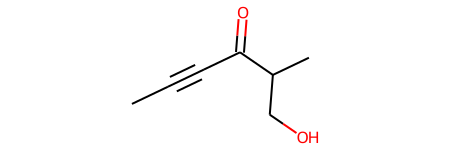

CC#CC(=O)C(C)CO


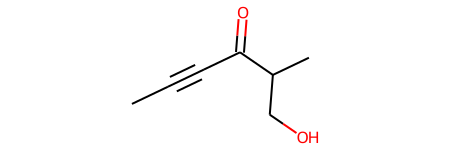

CC#CC(=O)C(C)CO


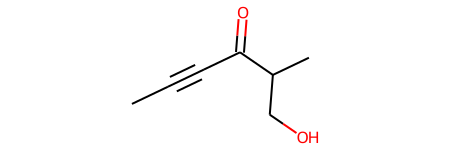

CC#CC(=O)C(C)CO


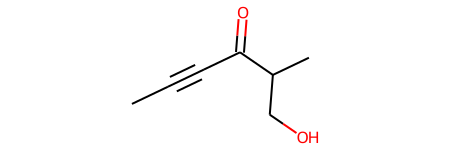

CC#CC(=O)C(C)CO


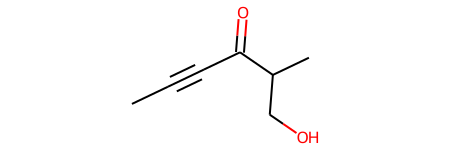

CC#CC(=O)C(C)CO


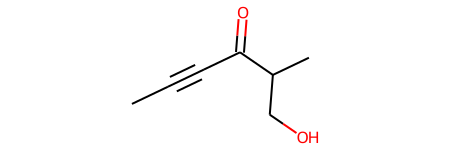

CC#CC(=O)C(C)CO


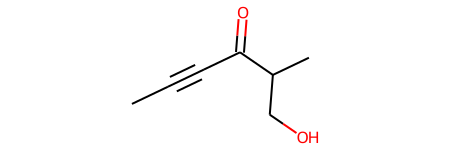

CC#CC(=O)C(C)CO


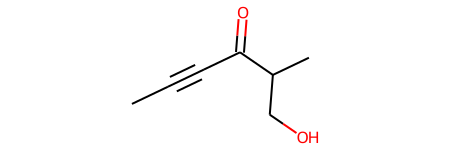

CC#CC(=O)C(C)CO


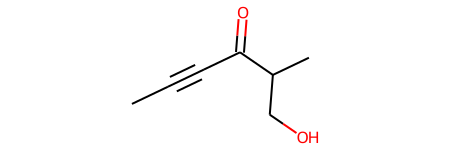

CC#CC(=O)C(C)CO


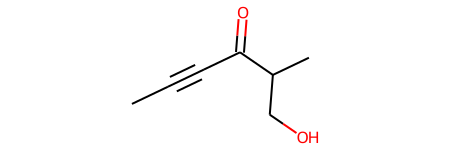

CC#CC(=O)C(C)CO


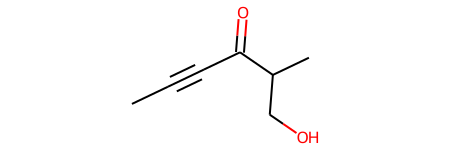

CC#CC(=O)C(C)CO


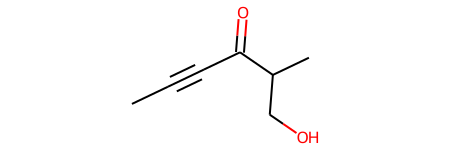

CC#CC(=O)C(C)CO


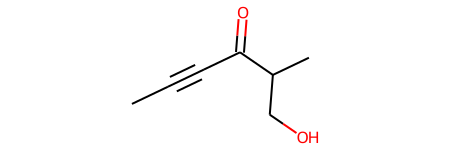

CC#CC(=O)C(C)CO


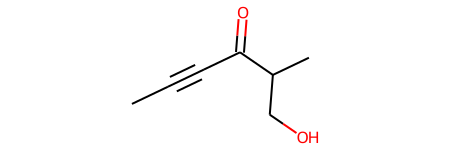

CC#CC(=O)C(C)CO


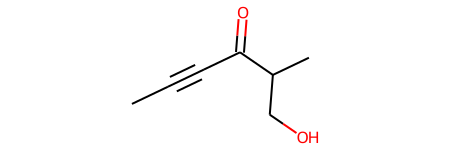

CC#CC(=O)C(C)CO


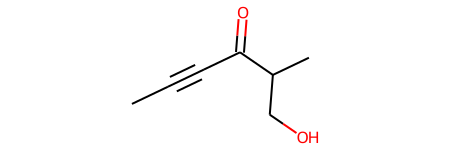

CC#CC(=O)C(C)CO


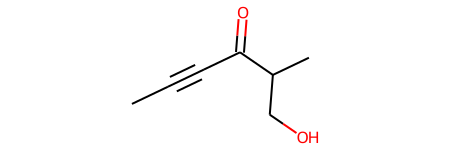

CC#CC(=O)C(C)CO


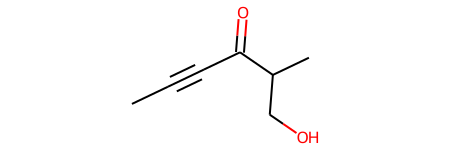

CC#CC(=O)C(C)CO


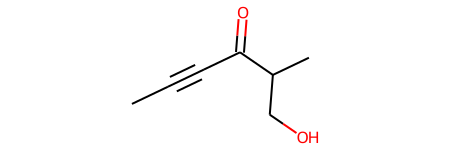

CC#CC(=O)C(C)CO


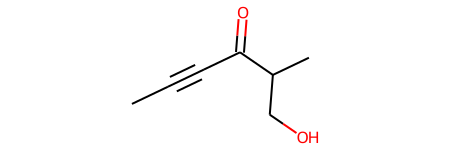

CC#CC(=O)C(C)CO


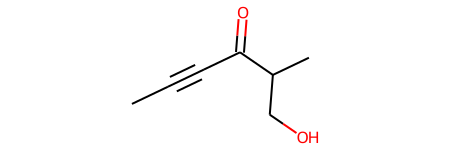

CC#CC(=O)C(C)CO


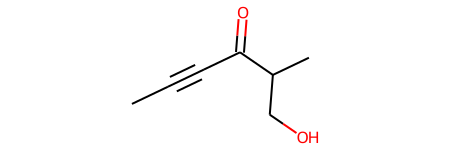

CC#CC(=O)C(C)CO


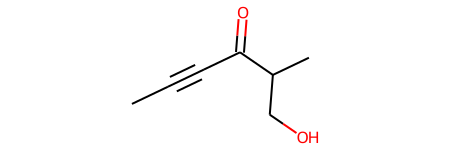

CC#CC(=O)C(C)CO


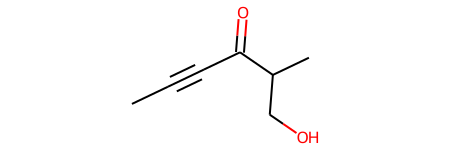

CC#CC(=O)C(C)CO


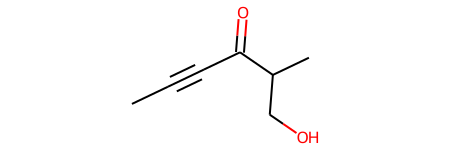

CC#CC(=O)C(C)CO


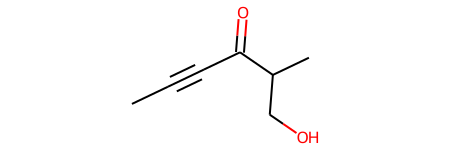

CC#CC(=O)C(C)CO


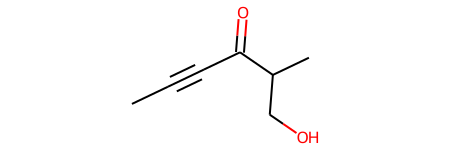

CC#CC(=O)C(C)CO


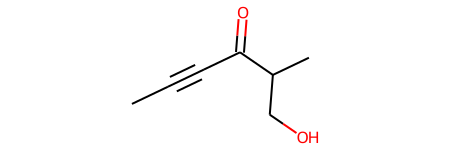

CC#CC(=O)C(C)CO


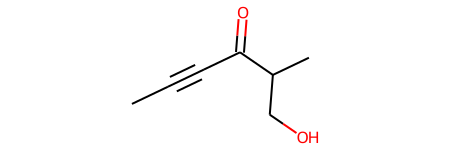

CC#CC(=O)C(C)CO


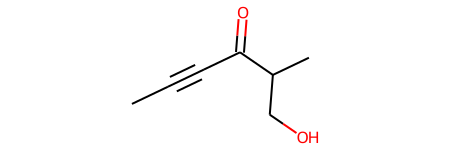

CC#CC(=O)C(C)CO


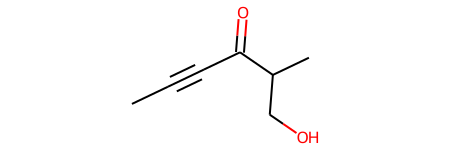

CC#CC(=O)C(C)CO


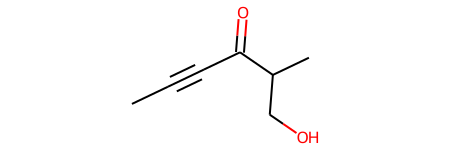

CC#CC(=O)C(C)CO


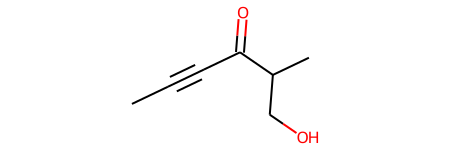

CC#CC(=O)C(C)CO


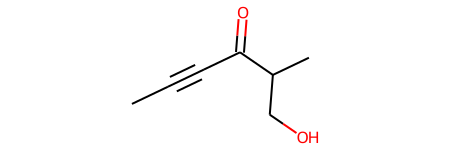

CC#CC(=O)C(C)CO


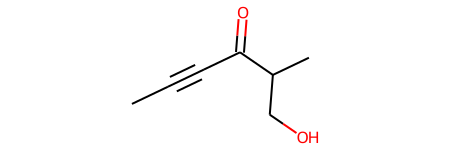

CC#CC(=O)C(C)CO


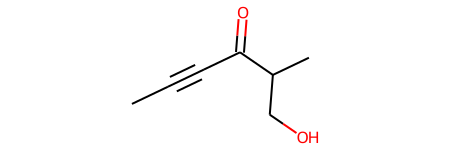

CC#CC(=O)C(C)CO


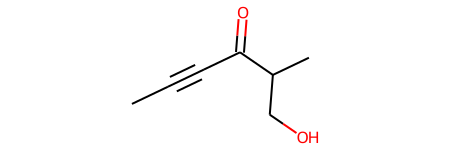

CC#CC(=O)C(C)CO


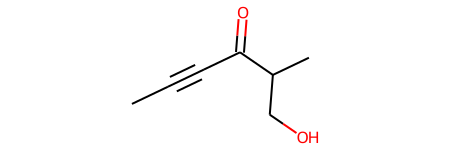

CC#CC(=O)C(C)CO


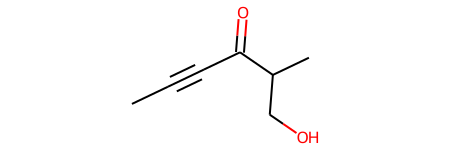

CC#CC(=O)C(C)CO


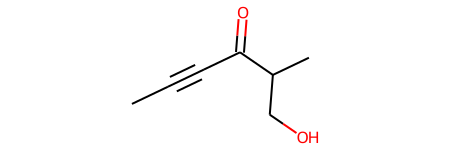

CC#CC(=O)C(C)CO


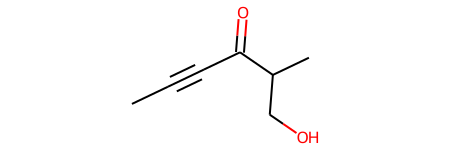

CC#CC(=O)C(C)CO


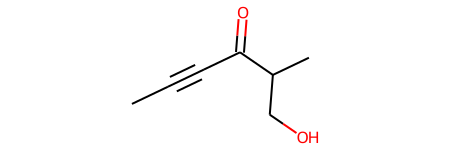

CC#CC(=O)C(C)CO


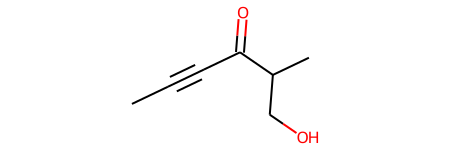

CC#CC(=O)C(C)CO


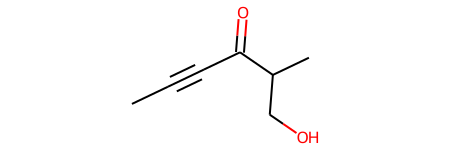

CC#CC(=O)C(C)CO


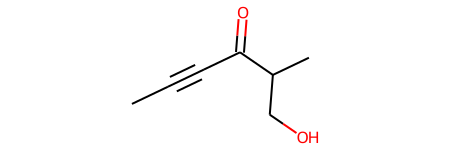

CC#CC(=O)C(C)CO


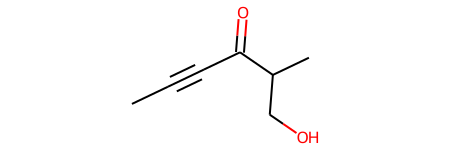

CC#CC(=O)C(C)CO


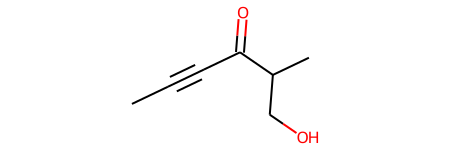

CC#CC(=O)C(C)CO


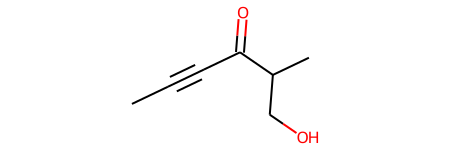

CC#CC(=O)C(C)CO


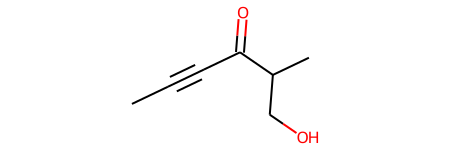

CC#CC(=O)C(C)CO


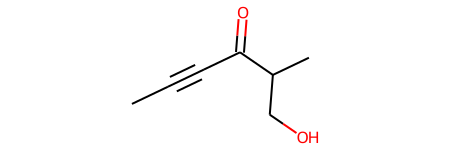

CC#CC(=O)C(C)CO


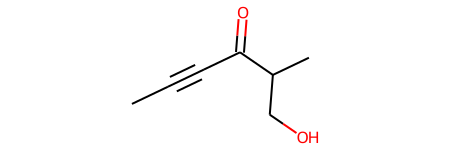

CC#CC(=O)C(C)CO


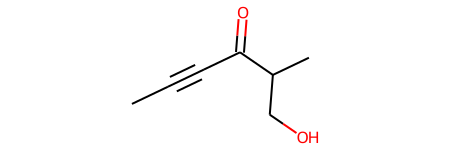

CC#CC(=O)C(C)CO


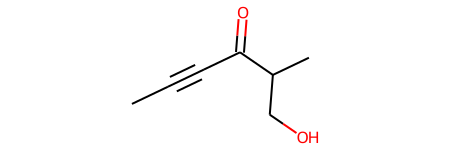

CC#CC(=O)C(C)CO


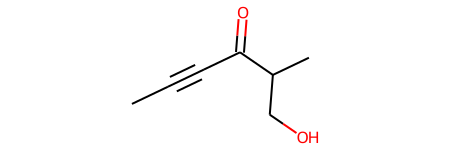

CC#CC(=O)C(C)CO


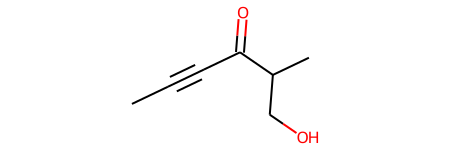

CC#CC(=O)C(C)CO


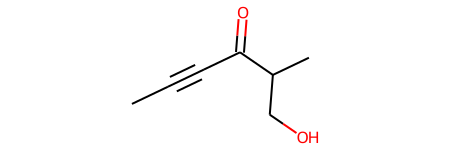

CC#CC(=O)C(C)CO


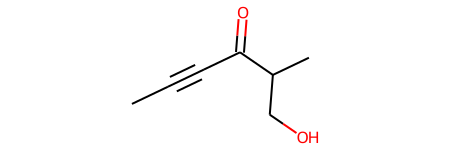

CC#CC(=O)C(C)CO


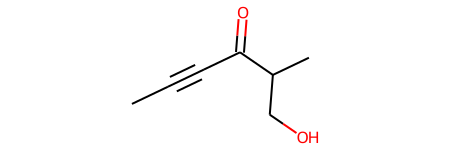

CC#CC(=O)C(C)CO


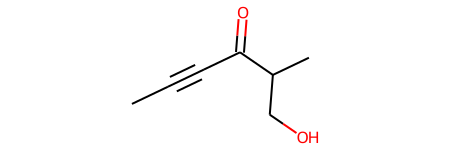

CC#CC(=O)C(C)CO


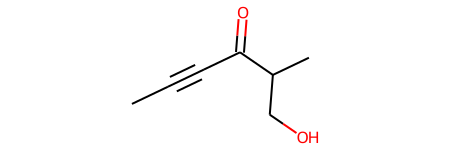

CC#CC(=O)C(C)CO


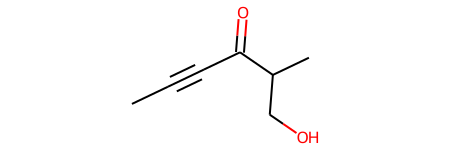

CC#CC(=O)C(C)CO


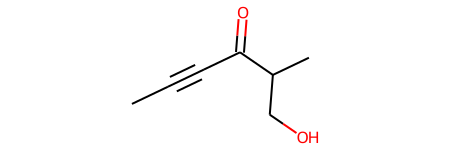

CC#CC(=O)C(C)CO


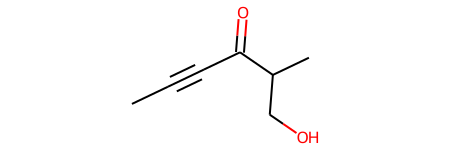

CC#CC(=O)C(C)CO


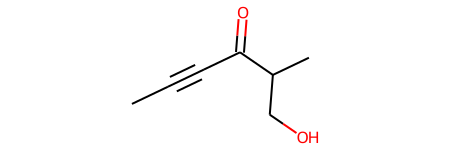

CC#CC(=O)C(C)CO


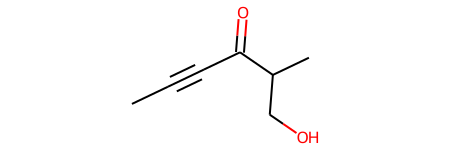

CC#CC(=O)C(C)CO


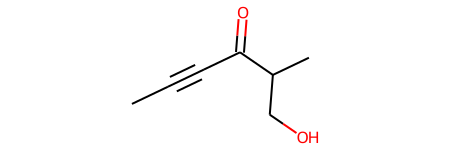

CC#CC(=O)C(C)CO


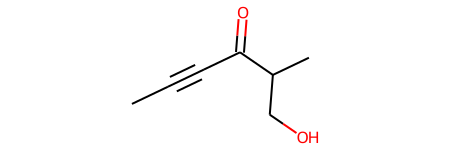

CC#CC(=O)C(C)CO


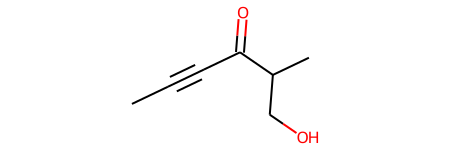

CC#CC(=O)C(C)CO


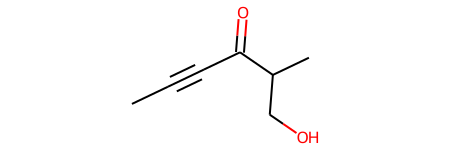

CC#CC(=O)C(C)CO


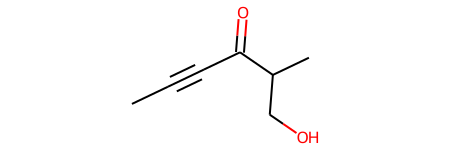

CC#CC(=O)C(C)CO


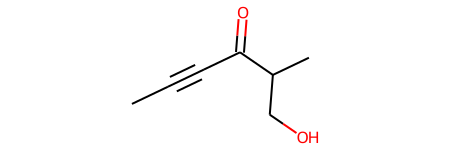

CC#CC(=O)C(C)CO


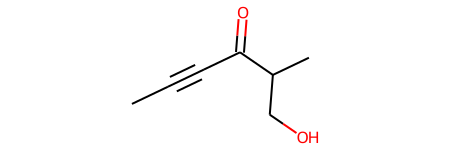

CC#CC(=O)C(C)CO


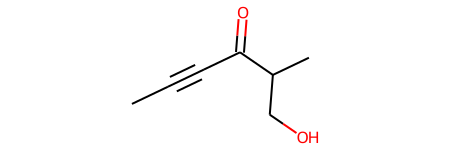

CC#CC(=O)C(C)CO


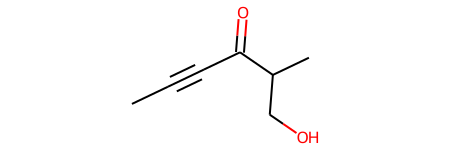

CC#CC(=O)C(C)CO


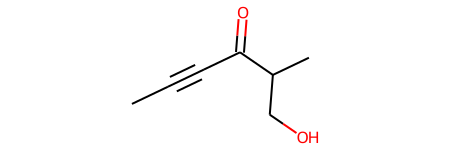

CC#CC(=O)C(C)CO


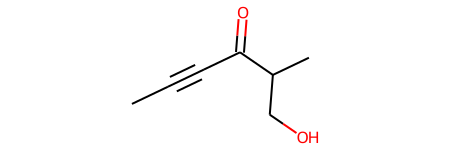

CC#CC(=O)C(C)CO


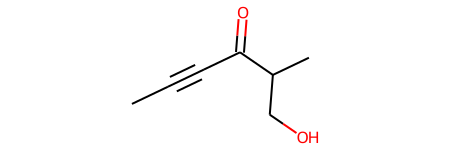

CC#CC(=O)C(C)CO


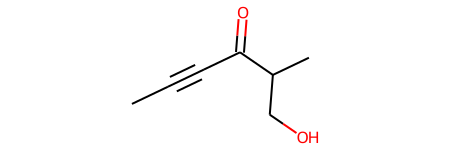

CC#CC(=O)C(C)CO


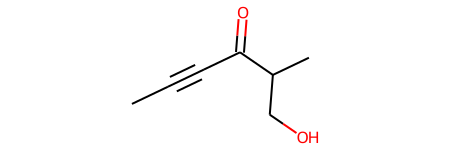

CC#CC(=O)C(C)CO


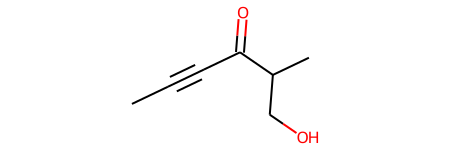

CC#CC(=O)C(C)CO


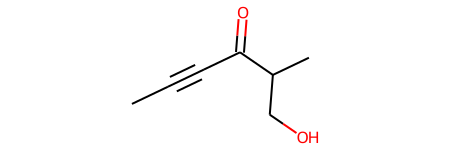

CC#CC(=O)C(C)CO


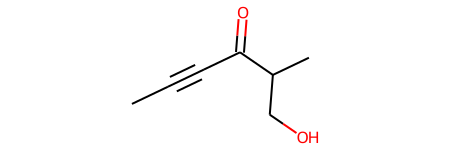

CC#CC(=O)C(C)CO


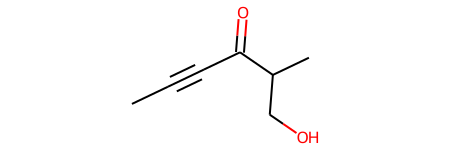

CC#CC(=O)C(C)CO


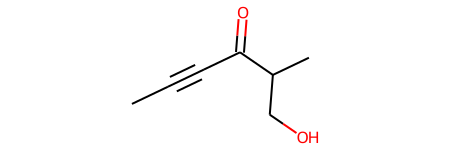

CC#CC(=O)C(C)CO


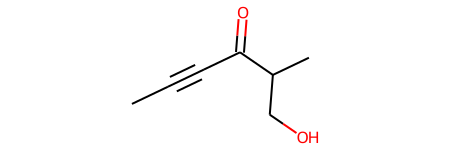

CC#CC(=O)C(C)CO


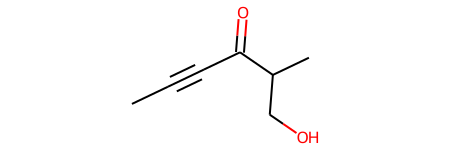

CC#CC(=O)C(C)CO


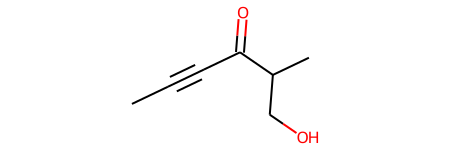

CC#CC(=O)C(C)CO


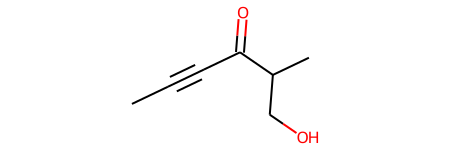

CC#CC(=O)C(C)CO


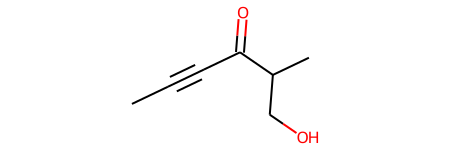

CC#CC(=O)C(C)CO


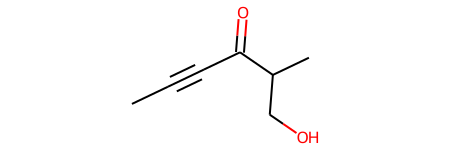

CC#CC(=O)C(C)CO


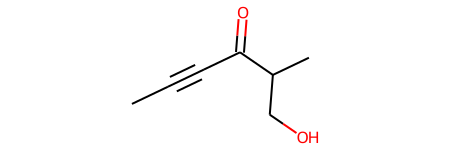

CC#CC(=O)C(C)CO


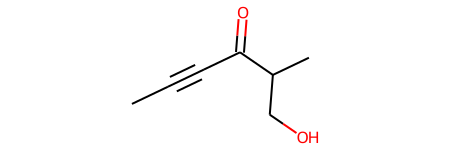

CC#CC(=O)C(C)CO


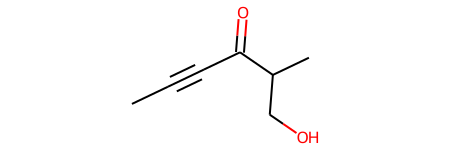

CC#CC(=O)C(C)CO


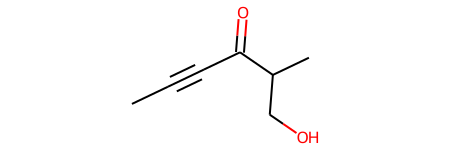

CC#CC(=O)C(C)CO


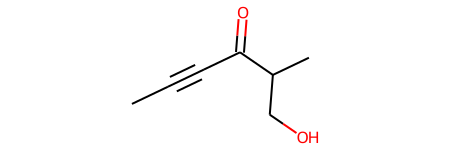

CC#CC(=O)C(C)CO


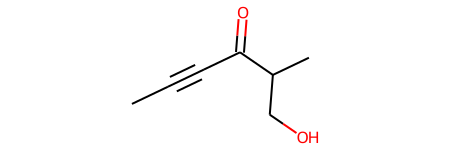

CC#CC(=O)C(C)CO


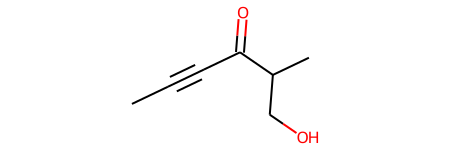

CC#CC(=O)C(C)CO


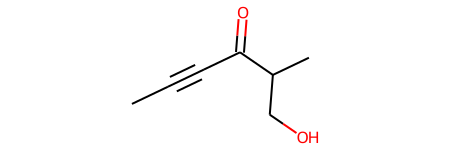

CC#CC(=O)C(C)CO


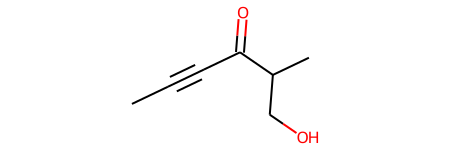

In [15]:
i=100
for i in range(i):
    # RANDOM TENSOR
    fancy_latent_point = torch.randn(1, 1, vae_encoder.latent_dimension,
                                     device=device)




    # FROM EXAMPLE TENSOR (FOR RECONSTRUCTION TESTING)

    # We start with a known SMILES string, in our example this is the representation for an organic molecule

    #smiles = "CCCCC"
    smiles = "CC#CC(=O)C(C)CO"
#     smiles = "CC(=O)OC1=CC=CC=C1C(=O)O"
#     Donor
#     smiles = "CC(SC1=C2C3=CC=C(CC(CC)CCCC)S3)=CC1=C(C4=CC=C(CC(CC)CCCC)S4)C5=C2C=C(C6=CC7=C(C(SC(C)=C8)=C8C(N7CC(CCCCCCCC)CCCCCCCCCC)=O)S6)S5"
#     smiles = "CC1=CC(CCCCCC)=C(C)S1"
#     smiles = "CC1=CC(C(S1)=C2C3=CC(Cl)=C(CC(CC)CCCC)S3)=C(C4=C2C=C(C5=CC=C(C6=C(OC)C(OC)=C(C7=CC=C(C)S7)C8=NN(CC(CCCCCC)CCCCCCCC)N=C68)S5)S4)C9=CC(Cl)=C(CC(CC)CCCC)S9"
    #Acceptor
#     smiles = "CCCCCC(N(C(C1=CC=C2C(C=CC34)=C5C4C(C(N(C6=CC=C(C7(CCCCC7)C8=CC=C(N(C9=O)C(C%10=CC=C%11C%12=C(C%13=CC=C(C%14=C%13C%11=CC=C%15%14)C(N(C%15=O)C(CCCCC)CCCCC)=O)C=CC9C%10%12)=O)C=C8)C=C6)C3=O)=O)=CC=C5C%16=CC=C%17C1=C2%16)=O)C%17=O)CCCCC"
#     smiles = "O=C(N1CCCCCC)C2=CC(C3=C4C5=C(C6=C3)C(C7=C58)=C(C=C6)C=CC7=CC=C8C=C4)=CC=C2C1=O"
#     smiles = "COC1=CC(C2C3C=CC(OC)=C2)=C(/C3=C4C(C=C(C=CC=C5)C5=C6)=C6C7=C/4C=C8C(C=CC=C8)=C7)C=C1"
#     smiles = "O=C(C(C=CC=C1)=C1C/2=C(C#N)/C#N)C2=C/C3=CC(SC4=C5C(C6=CC=C(CCC)C=C6)(C7=CC=C(CCC)C=C7)C8=C4SC9=C8C(CCCCCCCCCCCC)=C%10SC%11=C(C%10=C9CCCCCCCCCCCC)C(C%12=CC=C(CCC)C=C%12)(C%13=CC=C(CCC)C=C%13)C%14=C%11SC%15=C%14SC(/C=C%16C(C(C=CC=C%17)=C%17C\%16=C(C#N)\C#N)=O)=C%15)=C5S3"
    # print(f"Original SMILES: {smiles} \n")

    # We can also visualize the molecule itself from the SMILES string
    # can_image = Chem.MolFromSmiles(smiles)
    # display(can_image)

    # We can then transform this SMILES string into the new SELFIES string representation
    encoded_selfies = sf.encoder(smiles)  # SMILES --> SEFLIES
    # print(f"Translated SELFIES: {encoded_selfies} \n")


    example = multiple_selfies_to_hot([encoded_selfies], largest_molecule_len, encoding_alphabet)
    example = torch.tensor(example, dtype=torch.float).to(device)


    out_one_hot = torch.zeros_like(example, device=device)
    one_hot_flat_example = example.flatten(start_dim=1)


    example_latent_point, example_mu, example_log_var = vae_encoder(one_hot_flat_example)
    example_latent_point = example_latent_point.unsqueeze(0)

    # print(example_latent_point)
    # print(type(example_latent_point))
    # print(example_latent_point.shape)

    hidden = vae_decoder.init_hidden(batch_size=1)

    # runs over letters from molecules (len=size of largest molecule)

    for seq_index in range(21):
        out_one_hot_line, hidden = vae_decoder(example_latent_point, hidden)
        out_one_hot[:,seq_index] = out_one_hot_line[0]


    example_indices = example.reshape(-1, example.shape[2]).argmax(1)
    out_one_hot_indices = out_one_hot.reshape(-1, out_one_hot.shape[2]).argmax(1)

    differences = 1. - torch.abs(out_one_hot_indices - example_indices)
    differences = torch.clamp(differences, min=0., max=1.).double()

    quality = 100. * torch.mean(differences)
    quality = quality.detach().cpu().numpy()

    # print(out_one_hot_indices)
    # print(differences)
    # print(quality)


    sampled_selfies = ''.join([encoding_alphabet[tag] for tag in out_one_hot_indices])
#     print(sampled_selfies)

    sampled_selfies_index = sf.decoder(sampled_selfies)  # SELFIES --> SMILES
    print(sampled_selfies_index)
    sampled_selfies_image = Chem.MolFromSmiles(sampled_selfies_index)
    display(sampled_selfies_image)